## OpenBioLLM Baseline vs Fine Tuning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

offload_directory = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Fine-Tuning/FineTune_OpenBioLLM/Model_Offload"
output_directory = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Fine-Tuning/FineTune_OpenBioLLM/Model_Output"

Mounted at /content/drive


In [2]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    default_data_collator,
    EarlyStoppingCallback,
    DataCollatorWithPadding
)
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)

    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    auc = roc_auc_score(labels, probs[:, 1])

    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return {
        "accuracy": acc,
        "precision": precision,
        "recall/sensitivity": recall,
        "specificity": specificity,
        "f1": f1,
        "auc": auc,
        "true_positives": tp,
        "false_positives": fp,
        "true_negatives": tn,
        "false_negatives": fn
    }

In [5]:
model_id = "aaditya/Llama3-OpenBioLLM-8B"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Add a padding token if the tokenizer does not have one.
# Using eos_token is a common practice if appropriate for the task.
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        # As a fallback, add a new padding token
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        # You might need to resize the model's token embedding layer
        # base_model.resize_token_embeddings(len(tokenizer)) # uncomment if you add a new token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

### Prepare Dataset

In [7]:
# Load data
file_path_alvin = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Fine-Tuning/Updated_Data with 4000/Updated_formatted_blended_data.csv"

df = pd.read_csv(file_path_alvin)

df.head(5)

,text,label
0,age: 67 / sex: M / heart_rate: 148 / bp_systol...,1
1,age: 74 / sex: M / heart_rate: 96 / bp_systoli...,1
2,age: 3 / sex: M / heart_rate: 89 / bp_systolic...,1
3,age: 28 / sex: M / heart_rate: 147 / bp_systol...,1
4,age: 19 / sex: M / heart_rate: 65 / bp_systoli...,0


In [8]:
print(df["label"].value_counts())

label
0    3040
1    1360
Name: count, dtype: int64


In [9]:
df_majority = df[df.label == 0]
df_minority = df[df.label == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,                      # sample with replacement
    n_samples=len(df_majority),        # match majority size
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced.label.value_counts())

label
1    3040
0    3040
Name: count, dtype: int64


In [10]:
df = df.rename(columns={"label":"labels"})
hf_ds = Dataset.from_pandas(df.reset_index(drop=True))

def preprocess(batch):
    toks = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )
    return {
        "input_ids": toks["input_ids"],
        "attention_mask": toks["attention_mask"],
    }

hf_ds = hf_ds.map(preprocess, batched=True)

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

In [11]:
hf_ds.set_format(None)

In [12]:
try:
    python_item = hf_ds[0]
    print("Successfully accessed item with no format (raw Python objects).")
    # Manual conversion to torch if needed for inspection
    # Note: This manual conversion here is just for inspection and confirmation,
    # the DataCollatorWithPadding handles this for training batches.
    torch_item_for_inspection = {
        "input_ids": torch.tensor(python_item["input_ids"], dtype=torch.long),
        "attention_mask": torch.tensor(python_item["attention_mask"], dtype=torch.long),
        "labels": torch.tensor(python_item["labels"], dtype=torch.long) # Or torch.float if needed
    }
    print("Manually converted raw data to torch tensors for inspection:")
    print(torch_item_for_inspection)
except Exception as e:
     print(f"Accessing item with no format failed: {e}")
     print("Something is very wrong if even raw access fails.")

Successfully accessed item with no format (raw Python objects).
Manually converted raw data to torch tensors for inspection:
{'input_ids': tensor([  425,    25,   220,  3080,   611,  1877,    25,   386,   611,  4851,
         9430,    25,   220, 10410,   611, 27783,   646,   599,  7918,    25,
          220, 10828,   611, 27783, 30577,   561,  7918,    25,   220,  3080,
          611,  9216,  9430,    25,   220,  1682,   611,  9499,   932,    25,
          220,  1806,    13,    23,   611, 24463, 52403,  2060,    25,   220,
         6281,    13,    15,   611,   469, 14137,    25,   220,    20,   611,
         3293, 10232,  5287,    62,   966,    67,    25,   220,    15,   611,
          220,   220,  3080,  4771,  6418,  8762, 18911,   449, 34653,   369,
          220,    17,  4207,    11, 22359,   220,    22,    14,   605,    13,
         1952,   751,  1306,   264,  4498,    11,  5938,   449, 27331, 40700,
           13,  9973,   552,  3293,  5944,   477, 14363, 19015,    13, 24561,
   

In [13]:
train_test = hf_ds.train_test_split(test_size=0.2, seed=42)
train_ds, val_ds = train_test["train"], train_test["test"]

In [14]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
train_labels = [example['labels'] for example in train_ds]

class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Computed class weights: {class_weights_tensor}")

Computed class weights: tensor([0.7216, 1.6281], device='cuda:0')


### Baseline Model Evaluation

In [21]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # this will automate the model to be loaded based on what is available, if using CPU disable this line
    offload_folder=offload_directory,
)

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
if baseline_model.config.pad_token_id is None:
     # Set the model's pad_token_id to the tokenizer's pad_token_id
     baseline_model.config.pad_token_id = tokenizer.pad_token_id

In [27]:
baseline_training_args = TrainingArguments(
    output_dir=f"{output_directory}_Baseline_Eval", # Use a different output directory
    per_device_eval_batch_size=2, # Adjust batch size as needed
    do_train=False,
    do_eval=True,
    report_to="none",
    dataloader_pin_memory=False,
)

In [28]:
baseline_trainer = Trainer(
    model=baseline_model,
    args=baseline_training_args,
    tokenizer=tokenizer,
    eval_dataset=val_ds, # Use your validation dataset
    data_collator=data_collator, # Use the same data collator
    compute_metrics=compute_metrics, # Use the same compute_metrics function
)

<ipython-input-28-b46db7913a19>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  baseline_trainer = Trainer(


In [29]:
print("Evaluating baseline model...")
baseline_metrics = baseline_trainer.evaluate()
print("Baseline Model Evaluation Metrics:")
print(baseline_metrics)

Evaluating baseline model...


Baseline Model Evaluation Metrics:
{'eval_loss': 1.0971078872680664, 'eval_model_preparation_time': 0.0047, 'eval_accuracy': 0.6409090909090909, 'eval_precision': 0.28735632183908044, 'eval_recall/sensitivity': 0.08960573476702509, 'eval_specificity': 0.8968386023294509, 'eval_f1': 0.1366120218579235, 'eval_auc': 0.504141842448965, 'eval_true_positives': 25, 'eval_false_positives': 62, 'eval_true_negatives': 539, 'eval_false_negatives': 254, 'eval_runtime': 100.2032, 'eval_samples_per_second': 8.782, 'eval_steps_per_second': 4.391}


### Model Training (Skip if Using Saved Model State)

In [16]:
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # this will automate the model to be loaded based on what is available, if using CPU disable this line
    offload_folder=offload_directory,
)

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
if base_model.config.pad_token_id is None:
     # Set the model's pad_token_id to the tokenizer's pad_token_id
     base_model.config.pad_token_id = tokenizer.pad_token_id

In [18]:
for name, module in base_model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(name)

model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj
model.layers.1.self_attn.q_proj
model.layers.1.self_attn.k_proj
model.layers.1.self_attn.v_proj
model.layers.1.self_attn.o_proj
model.layers.1.mlp.gate_proj
model.layers.1.mlp.up_proj
model.layers.1.mlp.down_proj
model.layers.2.self_attn.q_proj
model.layers.2.self_attn.k_proj
model.layers.2.self_attn.v_proj
model.layers.2.self_attn.o_proj
model.layers.2.mlp.gate_proj
model.layers.2.mlp.up_proj
model.layers.2.mlp.down_proj
model.layers.3.self_attn.q_proj
model.layers.3.self_attn.k_proj
model.layers.3.self_attn.v_proj
model.layers.3.self_attn.o_proj
model.layers.3.mlp.gate_proj
model.layers.3.mlp.up_proj
model.layers.3.mlp.down_proj
model.layers.4.self_attn.q_proj
model.layers.4.self_attn.k_proj
model.layers.4.self_attn.v_proj
model.layers.4.self_attn.o_proj
model.layers.4.mlp.g

In [ ]:
# model.unload() # execute this when u rerun lora_config

In [19]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(base_model, lora_config)

In [20]:
# Access the classifier layer and set the weights
if hasattr(model.base_model, 'score'): # Common for some models
    model.base_model.score.weight = class_weights_tensor
elif hasattr(model.base_model, 'classifier'): # Common for others
    # You might need to adjust how you set the weight depending on the classifier structure
    if hasattr(model.base_model.classifier, 'weight'):
          model.base_model.classifier.weight = class_weights_tensor
    elif hasattr(model.base_model.classifier, 'dense') and hasattr(model.base_model.classifier.dense, 'weight'):
          model.base_model.classifier.dense.weight = class_weights_tensor
    # Add more checks if needed for your specific model architecture
else:
    print("Could not find a common classifier attribute. You might need to inspect your model's structure to set class weights.")

In [21]:
# Sanity check: You should see trainable parameters, and not zero
model.print_trainable_parameters()

trainable params: 6,823,936 || all params: 7,511,756,800 || trainable%: 0.0908


In [22]:
training_args = TrainingArguments(
    output_dir=output_directory,
    per_device_train_batch_size=2, # increase this if allows
    gradient_accumulation_steps=8, # decrease this if allowed
    num_train_epochs=10,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    optim="adamw_torch",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
    label_names=['labels'],
    dataloader_pin_memory=False, # pin memory when using GPU
    gradient_checkpointing=True,
)

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

<ipython-input-23-6542145e665c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall/sensitivity,Specificity,F1,Auc,True Positives,False Positives,True Negatives,False Negatives
1,0.633700,0.774589,0.626136,0.367021,0.247312,0.801997,0.295503,0.532941,69,119,482,210
2,0.733700,0.708851,0.629545,0.384236,0.279570,0.792013,0.323651,0.536033,78,125,476,201
3,0.681300,0.691852,0.648864,0.407407,0.236559,0.840266,0.299320,0.541222,66,96,505,213
4,0.585000,0.694331,0.675000,0.456790,0.132616,0.926789,0.205556,0.544442,37,44,557,242
5,0.739500,0.684470,0.676136,0.466667,0.150538,0.920133,0.227642,0.548471,42,48,553,237
6,0.750200,0.683571,0.678409,0.475610,0.139785,0.928453,0.216066,0.549106,39,43,558,240
7,0.722400,0.676552,0.679545,0.483871,0.161290,0.920133,0.241935,0.550081,45,48,553,234
8,0.713300,0.674026,0.673864,0.467213,0.204301,0.891847,0.284289,0.549893,57,65,536,222
9,0.736300,0.674438,0.677273,0.473684,0.161290,0.916805,0.240642,0.550764,45,50,551,234
10,0.659400,0.673482,0.678409,0.480392,0.175627,0.911814,0.257218,0.550239,49,53,548,230


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn

TrainOutput(global_step=2200, training_loss=0.7846542713858865, metrics={'train_runtime': 1916.8653, 'train_samples_per_second': 18.363, 'train_steps_per_second': 1.148, 'total_flos': 1.888680897675264e+17, 'train_loss': 0.7846542713858865, 'epoch': 10.0})

In [25]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.6734824180603027, 'eval_accuracy': 0.678409090909091, 'eval_precision': 0.4803921568627451, 'eval_recall/sensitivity': 0.17562724014336917, 'eval_specificity': 0.9118136439267887, 'eval_f1': 0.2572178477690289, 'eval_auc': 0.5502388492297783, 'eval_true_positives': 49, 'eval_false_positives': 53, 'eval_true_negatives': 548, 'eval_false_negatives': 230, 'eval_runtime': 14.9178, 'eval_samples_per_second': 58.99, 'eval_steps_per_second': 7.374, 'epoch': 10.0}


## Model Improvement

### Reload Saved Model

In [15]:
from peft import PeftModel

# Loading saved model states

checkpoint_path = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Fine-Tuning/FineTune_OpenBioLLM/Model_Output/checkpoint2200-trainedon4000"
output_path = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Fine-Tuning/FineTune_OpenBioLLM/Model_Output"

tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

reload_base_model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=2,
    torch_dtype=torch.float32,
    device_map="auto", # Update this
    low_cpu_mem_usage=True,
)

if reload_base_model.config.pad_token_id is None:
     # Set the model's pad_token_id to the tokenizer's pad_token_id
     reload_base_model.config.pad_token_id = tokenizer.pad_token_id

model = PeftModel.from_pretrained(reload_base_model, checkpoint_path)
model.eval()

training_args = TrainingArguments(
    output_dir=output_path,
    per_device_eval_batch_size=4,
    do_train=False,
    do_eval=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
)

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-15-e9df9c955609>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.7155243158340454, 'eval_model_preparation_time': 0.0171, 'eval_accuracy': 0.6534090909090909, 'eval_precision': 0.3673469387755102, 'eval_recall/sensitivity': 0.12903225806451613, 'eval_specificity': 0.8968386023294509, 'eval_f1': 0.1909814323607427, 'eval_auc': 0.4934666833652395, 'eval_true_positives': 36, 'eval_false_positives': 62, 'eval_true_negatives': 539, 'eval_false_negatives': 243, 'eval_runtime': 99.9271, 'eval_samples_per_second': 8.806, 'eval_steps_per_second': 2.202}


### Finding Optimal Threshold

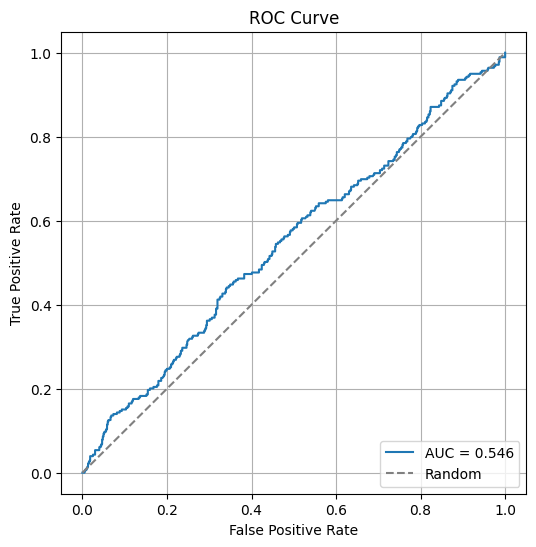

 threshold  accuracy  precision   recall       f1
      0.00  0.317045   0.317045 1.000000 0.481450
      0.05  0.322727   0.317606 0.989247 0.480836
      0.10  0.332955   0.317102 0.956989 0.476360
      0.15  0.379545   0.325490 0.892473 0.477011
      0.20  0.415909   0.320611 0.752688 0.449679
      0.25  0.504545   0.347573 0.641577 0.450882
      0.30  0.565909   0.359673 0.473118 0.408669
      0.35  0.601136   0.358268 0.326165 0.341463
      0.40  0.628409   0.353659 0.207885 0.261851
      0.45  0.660227   0.405660 0.154122 0.223377
      0.50  0.677273   0.466667 0.125448 0.197740
      0.55  0.677273   0.454545 0.089606 0.149701
      0.60  0.673864   0.394737 0.053763 0.094637
      0.65  0.678409   0.428571 0.043011 0.078176
      0.70  0.679545   0.440000 0.039427 0.072368
      0.75  0.681818   0.478261 0.039427 0.072848
      0.80  0.679545   0.421053 0.028674 0.053691
      0.85  0.678409   0.300000 0.010753 0.020761
      0.90  0.680682   0.333333 0.007168 0.014035


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 1. Get raw predictions
pred_out = trainer.predict(val_ds)
logits = pred_out.predictions
labels = pred_out.label_ids

# 2. Convert logits → probabilities for the positive class
#    (softmax over the two logits)
exp = np.exp(logits)
probs = exp[:, 1] / exp.sum(axis=1)

# 3. Compute ROC curve & AUC
fpr, tpr, roc_thresholds = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

# 4. Plot the ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Sweep thresholds and compute metrics
thresholds = np.linspace(0.0, 1.0, 21)
rows = []
for thr in thresholds:
    preds = (probs >= thr).astype(int)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    rows.append({
        'threshold': thr,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

thresh_df = pd.DataFrame(rows)

# 6. Display the table
print(thresh_df.to_string(index=False))